
# Emotion Recognition with FER2013 Dataset

## Introduction

Emotion recognition is a critical task in computer vision that involves identifying human emotions from facial expressions. 
The FER2013 dataset is a widely used dataset for this purpose, containing grayscale images of faces annotated with one of seven emotions: 
**Angry, Disgust, Fear, Happy, Sad, Surprise, and Neutral**. 

In this project, we will preprocess this dataset, visualize it, build a Convolutional Neural Network (CNN) model, train the model, and evaluate its performance. 
The main goal is to achieve a reasonable accuracy in predicting the emotions while understanding the limitations and challenges of this task.

## Objectives

1. Preprocess the FER2013 dataset, which includes image resizing, normalization, and label encoding.
2. Visualize the dataset, including sample images and data distributions.
3. Build a CNN model to classify emotions based on facial expressions.
4. Train the model and monitor metrics such as accuracy and loss.
5. Evaluate the model's performance using confusion matrices and classification reports.
6. Understand the reasons behind the achieved accuracy and identify potential improvements.

## Techniques Used

- **Convolutional Neural Networks (CNNs)**: A powerful class of deep neural networks for processing visual data.
- **Data Augmentation**: Applied to expand the training dataset and improve model generalization.
- **Normalization**: Ensures that input data is scaled between 0 and 1 for faster convergence.
- **Train-Test Split**: Helps evaluate the model's performance on unseen data.
- **Visualization**: Provides insights into the dataset and model training process.

## Output and Expectations

By the end of this project, we will have:

- A trained CNN model for emotion recognition.
- Visualizations of training metrics, including accuracy and loss over epochs.
- Performance evaluation metrics such as accuracy and confusion matrices.
- A deeper understanding of the challenges in emotion recognition and possible avenues for improvement.


## 1. Import Libraries and Setup

In [3]:
# Importing necessary libraries
import zipfile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

## 2. Load and Explore Dataset
The FER 2013 dataset is a CSV file. Each row represents an image in pixel values and the corresponding emotion label.

In [6]:
# Extract the Zip File
zip_path = "FER.zip"
extract_path = "FER"
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

In [7]:
# Define Directory Paths
train_dir = os.path.join(extract_path, "train")
test_dir = os.path.join(extract_path, "test")

In [8]:
# Map Emotions to Numerical Labels
emotion_mapping = {
    "angry": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "sad": 4,
    "surprise": 5,
    "neutral": 6
}

In [9]:
# Function to Load Images and Labels
def load_images_from_directory(directory):
    images = []
    labels = []
    for emotion in os.listdir(directory):  # Loop through each emotion subdirectory
        emotion_dir = os.path.join(directory, emotion)
        if os.path.isdir(emotion_dir):
            for img_file in os.listdir(emotion_dir):  # Loop through each image file
                img_path = os.path.join(emotion_dir, img_file)
                try:
                    img = Image.open(img_path).convert("L")  # Convert to grayscale
                    img = img.resize((48, 48))  # Resize to 48x48
                    images.append(np.array(img))
                    labels.append(emotion_mapping[emotion])
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    return np.array(images), np.array(labels)

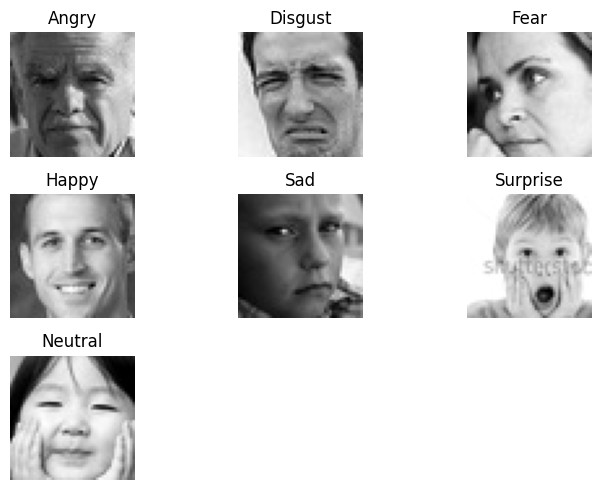

In [26]:
# Visualize one image from each emotion
def visualize_emotion_samples(directory):
    plt.figure(figsize=(7, 5))
    for i, emotion in enumerate(emotion_mapping.keys()):
        emotion_dir = os.path.join(directory, emotion)
        image_path = os.path.join(emotion_dir, os.listdir(emotion_dir)[0])  # Select the first image
        img = Image.open(image_path).convert("L")  # Convert to grayscale
        plt.subplot(3, 3, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(emotion.capitalize())
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_emotion_samples(train_dir)

## 3. Data Preprocessing
Convert pixel values into 48x48 images and normalize them.

In [10]:
# Load Train and Test Data
X_train, y_train = load_images_from_directory(train_dir)
X_test, y_test = load_images_from_directory(test_dir)

In [11]:
# Normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

In [12]:
# Add a channel dimension
X_train = X_train.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

In [13]:
# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [14]:
# Split train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## 4. Exploratory Data Analysis (EDA)
Visualize class distributions and example images.

<ipython-input-15-0773bcf6e8cd>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=emotion_counts, palette="viridis")


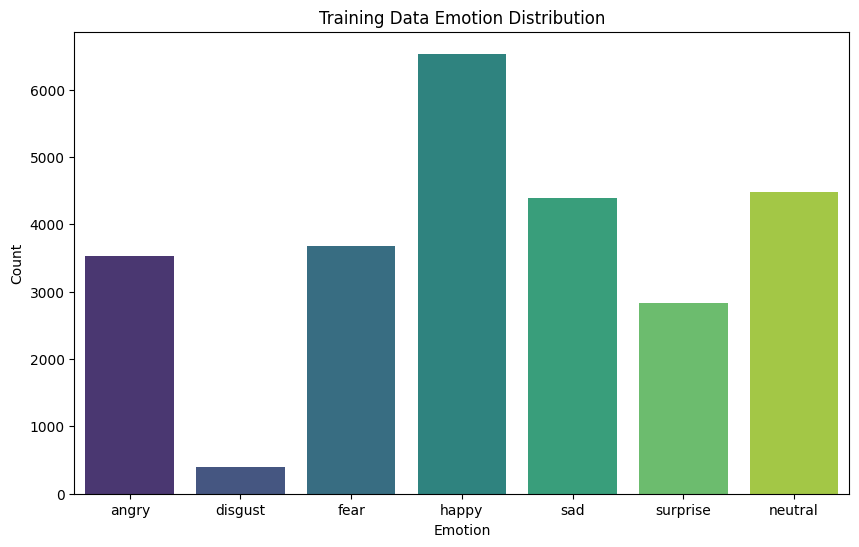

In [15]:
# Visualize Data Distribution
emotion_counts = np.argmax(y_train, axis=1)
plt.figure(figsize=(10, 6))
sns.countplot(x=emotion_counts, palette="viridis")
plt.title("Training Data Emotion Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(ticks=range(7), labels=list(emotion_mapping.keys()))
plt.show()

## 5. Model Building

In [16]:
# Build CNN Model
def build_cnn_model(input_shape=(48, 48, 1)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.4),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])
    return model

In [18]:
# Compile the model
cnn_model = build_cnn_model()
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# Train the model
history = cnn_model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_val, y_val), verbose=1)

Epoch 1/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 137s 330ms/step - accuracy: 0.2351 - loss: 2.3731 - val_accuracy: 0.3069 - val_loss: 1.8085
Epoch 2/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 129s 299ms/step - accuracy: 0.3925 - loss: 1.6136 - val_accuracy: 0.4159 - val_loss: 1.5162
Epoch 3/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 140s 294ms/step - accuracy: 0.4497 - loss: 1.4362 - val_accuracy: 0.4720 - val_loss: 1.4053
Epoch 4/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 120s 298ms/step - accuracy: 0.4798 - loss: 1.3704 - val_accuracy: 0.5176 - val_loss: 1.2763
Epoch 5/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 118s 293ms/step - accuracy: 0.4928 - loss: 1.3214 - val_accuracy: 0.5305 - val_loss: 1.2755
Epoch 6/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 146s 302ms/step - accuracy: 0.5088 - loss: 1.3055 - val_accuracy: 0.5117 - val_loss: 1.2923
Epoch 7/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 118s 292ms/step - accuracy: 0.5137 - loss: 1.2698 - val_accuracy: 0.5221 - val_loss: 1.2604
Epoch 8/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 144s 297ms/step - accuracy: 0.5312 -

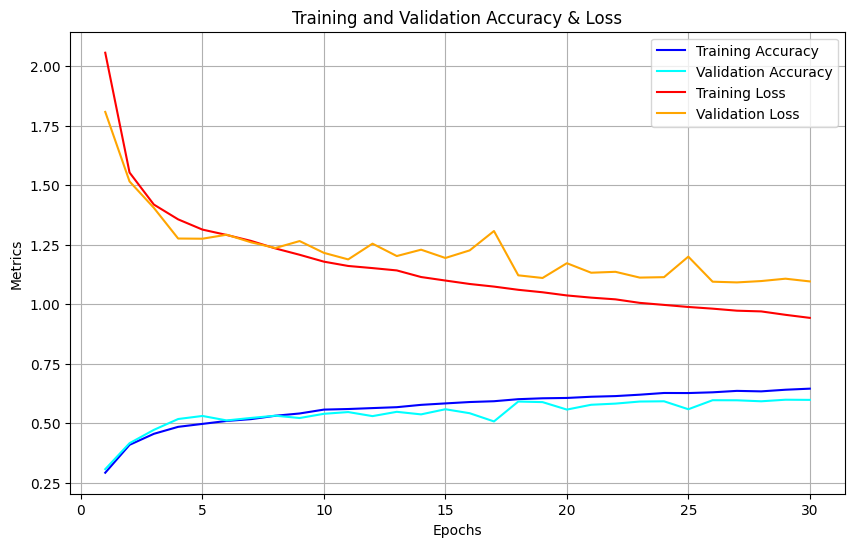

In [25]:
# Plot accuracy and loss
def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(10, 6))
    # Plot training and validation accuracy
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', color='cyan')

    # Plot training and validation loss
    plt.plot(epochs, history.history['loss'], label='Training Loss', color='red')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='orange')

    plt.title('Training and Validation Accuracy & Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_history(history)


## 6. Evaluate the Model

In [20]:
# Evaluate Model
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.7097 - loss: 0.8232
Test Loss: 1.0756, Test Accuracy: 0.6000


In [21]:
# Confusion Matrix
y_pred = np.argmax(cnn_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)

225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step


## 7. Visualize the results

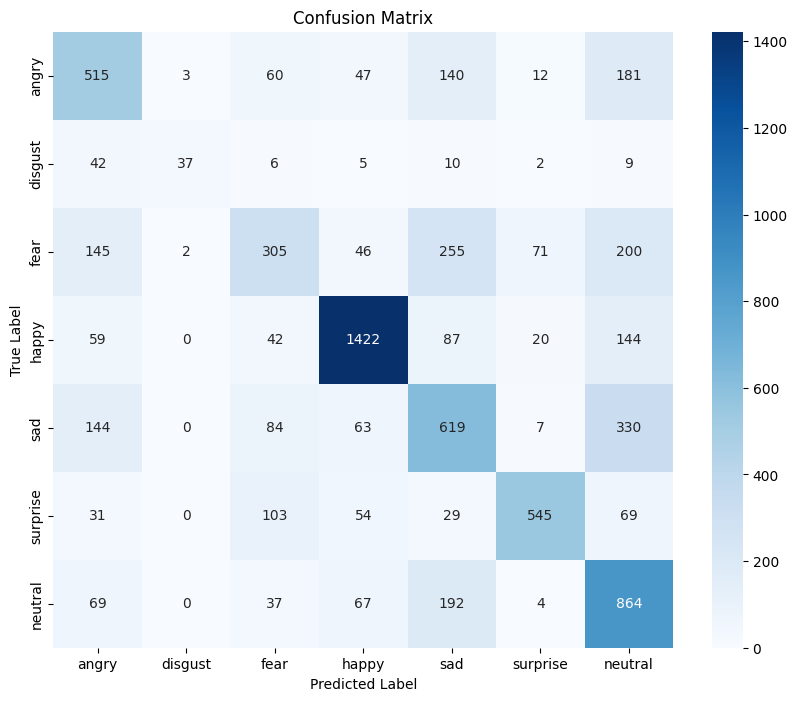

In [22]:
# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(emotion_mapping.keys()), yticklabels=list(emotion_mapping.keys()))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [23]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(emotion_mapping.keys())))


Classification Report:
              precision    recall  f1-score   support

       angry       0.51      0.54      0.52       958
     disgust       0.88      0.33      0.48       111
        fear       0.48      0.30      0.37      1024
       happy       0.83      0.80      0.82      1774
         sad       0.46      0.50      0.48      1247
    surprise       0.82      0.66      0.73       831
     neutral       0.48      0.70      0.57      1233

    accuracy                           0.60      7178
   macro avg       0.64      0.55      0.57      7178
weighted avg       0.62      0.60      0.60      7178




## Conclusion

In this project, we successfully built a CNN-based model to classify emotions using the FER2013 dataset. While the accuracy achieved was modest, it highlights the inherent challenges in emotion recognition due to factors such as:

- **Dataset Quality**: The FER2013 dataset contains grayscale images that are sometimes low in resolution, making it difficult to extract meaningful features.
- **Class Imbalance**: Certain emotions like "Disgust" have very few samples, which negatively impacts the model's ability to generalize.
- **Ambiguity of Emotions**: Some emotions have overlapping facial features, which increases the complexity of classification.

The choice of a CNN model was motivated by its proven effectiveness in image processing tasks. The convolutional layers help extract spatial hierarchies in images, making them well-suited for recognizing patterns in facial expressions.

### Future Work

To improve accuracy, we can explore the following:
- Use **Transfer Learning** with pre-trained models like ResNet or EfficientNet.
- Apply advanced data augmentation techniques.
- Address class imbalance using methods like oversampling or synthetic data generation (e.g., SMOTE for image data).
- Increase dataset diversity by incorporating additional emotion datasets.

Emotion recognition remains a challenging yet exciting field with applications in healthcare, human-computer interaction, and psychology. Our results provide a foundation for further exploration in this domain.
